In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow_hub as hub
import tensorflow as tf
import imutils

In [2]:
def plt_imshow(title,image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.title(title)
  plt.grid(False)
  plt.show()


In [35]:
IMAGE_PATH = '/content/runners.jpg'
LABELS = ['','person','bicycle','car','motorcycle']
COLORS = [(0,0,255),(0,255,0),(255,0,0)]
COLORS = [np.array(i).astype(int) for i in COLORS]

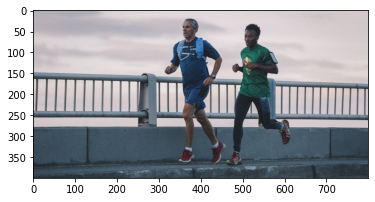

In [13]:
# preprocessing image 

image = cv2.imread(IMAGE_PATH)

image = imutils.resize(image,800)

rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(rgb)


In [ ]:
# converting to tensors for inserting into model

image_tensor = tf.convert_to_tensor(rgb , dtype=tf.uint8)

image_tensor = tf.expand_dims(image_tensor, axis=0)

image_tensor

In [6]:
# loading Mask RCNN model from tensorflow

detector = hub.load("https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1")


In [7]:
# running model

detector_output = detector(image_tensor)

In [8]:
detector_output.keys()

dict_keys(['proposal_boxes', 'final_anchors', 'mask_predictions', 'raw_detection_scores', 'rpn_features_to_crop', 'num_proposals', 'num_detections', 'detection_scores', 'raw_detection_boxes', 'rpn_box_predictor_features', 'anchors', 'proposal_boxes_normalized', 'detection_boxes', 'refined_box_encodings', 'box_classifier_features', 'detection_anchor_indices', 'detection_multiclass_scores', 'rpn_box_encodings', 'rpn_objectness_predictions_with_background', 'class_predictions_with_background', 'detection_classes', 'detection_masks', 'image_shape'])

In [31]:
# fetching outputs

classes = detector_output["detection_classes"][0].numpy().astype(int)
masks = detector_output["detection_masks"][0].numpy()
boxes = detector_output["detection_boxes"][0].numpy()
scores = detector_output["detection_scores"][0].numpy()


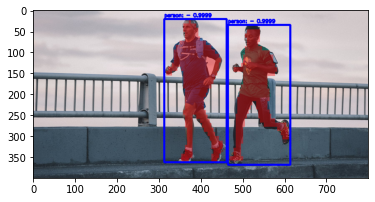

In [37]:
clone = rgb.copy()

(H,W) = rgb.shape[:2]

box = (boxes*np.array([H,W,H,W])).astype(int)

masks = (masks*255).astype("uint8")

# print(box)

for score, (ymin,xmin,ymax,xmax), label, mask in zip(scores,box,classes,masks):

  if score >0.8:

    # image segmentation - masks

    roi = clone[ymin:ymax,xmin:xmax]


    roi_height = ymax - ymin
    roi_width = xmax - xmin

    # Masking and fetching instance
    masking = cv2.resize(mask,(roi_width, roi_height),interpolation=cv2.INTER_NEAREST)
    instance = cv2.bitwise_and(roi,roi,mask=masking)

    # 70% threshold for predicted value of each pixel
    masking = (masking > 0.7*255)
    
    # blending mask with ROI
    roi_mask = roi[masking]
    blend = ((0.4* (np.array([255,0,0]).astype(int))) + (0.6*roi_mask)).astype("uint8")
    
    clone[ymin:ymax,xmin:xmax][masking] = blend

    # object detection - boxes
    img = cv2.rectangle(clone , (xmin,ymin), (xmax,ymax), (0,0,255),3)
    text = "{}: - {:.4f}".format(LABELS[label],score)
    img = cv2.putText( img, text, (xmin,ymin-5),cv2.FONT_HERSHEY_SIMPLEX, 0.40, (0,0,255),2)

    

# cv2_imshow(img)
plt.imshow(img)